# Tenable Data Science Technical Challenge: CVSS Prediction
### Michael Kenny

## Importing Libraries

In [2]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier     
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Getting Data

To download the data for this project I am using the Beautiful Soup module to scape the National Vulnerability Database webpage. As these feeds are updated once per day, this will allow for the analysis to be kept up to date with new CVE data.

Source: https://nvd.nist.gov/vuln/data-feeds

In [1]:
CVE_json_feed = open('jsonfiles.txt', 'w') # creating text file for json file links

In [3]:
url = 'https://nvd.nist.gov/vuln/data-feeds' 
baseurl = 'https://nvd.nist.gov'
page = requests.get(url)

soup = BeautifulSoup(page.content) # scraping data feed page

In [4]:
for anchor in soup.findAll('a', href=True): # writing all json.zip files to text file
    links = anchor['href']
    if links.endswith('.json.zip'):
        CVE_json_feed.write(links + '\n')

CVE_json_feed.close()

In [5]:
with open("jsonfiles.txt", "r+") as f: # removing not needed CVE-Modified, CPE Match and CVE-Recent files 
    d = f.readlines()
    f.seek(0)
    for i in d:
        if i not in ["/feeds/json/cpematch/1.0/nvdcpematch-1.0.json.zip\n",
                    '/feeds/json/cve/1.1/nvdcve-1.1-recent.json.zip\n',
                    '/feeds/json/cve/1.1/nvdcve-1.1-modified.json.zip\n']:
            f.write(i)
    f.truncate()

In [6]:
with open("jsonfiles.txt", "r") as f: # reading link names
    lines = f.readlines()

lines

['/feeds/json/cve/1.1/nvdcve-1.1-2022.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2021.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2020.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2019.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2018.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2017.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2016.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2015.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2014.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2013.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2012.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2011.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2010.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2009.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2008.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2007.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2006.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2005.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.1-2004.json.zip\n',
 '/feeds/json/cve/1.1/nvdcve-1.

In [7]:
with open('jsonfiles.txt', 'r') as links: # downloading files
    for link in links:
        if link:
            filename1 = link.split('/')[-1]
            filename = filename1[:-1]
            link = baseurl + link
            print(filename + ' file started to download')
            response = requests.get(link[:-1])

            with open(filename,'wb') as output_file:
                output_file.write(response.content)
            print(filename + 'file is downloaded')

nvdcve-1.1-2022.json.zip file started to download
nvdcve-1.1-2022.json.zipfile is downloaded
nvdcve-1.1-2021.json.zip file started to download
nvdcve-1.1-2021.json.zipfile is downloaded
nvdcve-1.1-2020.json.zip file started to download
nvdcve-1.1-2020.json.zipfile is downloaded
nvdcve-1.1-2019.json.zip file started to download
nvdcve-1.1-2019.json.zipfile is downloaded
nvdcve-1.1-2018.json.zip file started to download
nvdcve-1.1-2018.json.zipfile is downloaded
nvdcve-1.1-2017.json.zip file started to download
nvdcve-1.1-2017.json.zipfile is downloaded
nvdcve-1.1-2016.json.zip file started to download
nvdcve-1.1-2016.json.zipfile is downloaded
nvdcve-1.1-2015.json.zip file started to download
nvdcve-1.1-2015.json.zipfile is downloaded
nvdcve-1.1-2014.json.zip file started to download
nvdcve-1.1-2014.json.zipfile is downloaded
nvdcve-1.1-2013.json.zip file started to download
nvdcve-1.1-2013.json.zipfile is downloaded
nvdcve-1.1-2012.json.zip file started to download
nvdcve-1.1-2012.json

## Exploratory Data Analysis

In [349]:
cve_2002 = pd.read_json('nvdcve-1.1-2002.json.zip')
cve_2003 = pd.read_json('nvdcve-1.1-2003.json.zip')
cve_2004 = pd.read_json('nvdcve-1.1-2004.json.zip')
cve_2005 = pd.read_json('nvdcve-1.1-2005.json.zip')
cve_2006 = pd.read_json('nvdcve-1.1-2006.json.zip')
cve_2007 = pd.read_json('nvdcve-1.1-2007.json.zip')
cve_2008 = pd.read_json('nvdcve-1.1-2008.json.zip')
cve_2009 = pd.read_json('nvdcve-1.1-2009.json.zip')
cve_2010 = pd.read_json('nvdcve-1.1-2010.json.zip')
cve_2011 = pd.read_json('nvdcve-1.1-2011.json.zip')
cve_2012 = pd.read_json('nvdcve-1.1-2012.json.zip')
cve_2013 = pd.read_json('nvdcve-1.1-2013.json.zip')
cve_2014 = pd.read_json('nvdcve-1.1-2014.json.zip')
cve_2015 = pd.read_json('nvdcve-1.1-2015.json.zip')
cve_2016 = pd.read_json('nvdcve-1.1-2016.json.zip')
cve_2017 = pd.read_json('nvdcve-1.1-2017.json.zip')
cve_2018 = pd.read_json('nvdcve-1.1-2018.json.zip')
cve_2019 = pd.read_json('nvdcve-1.1-2019.json.zip')
cve_2020 = pd.read_json('nvdcve-1.1-2020.json.zip')
cve_2021 = pd.read_json('nvdcve-1.1-2021.json.zip')
cve_2022 = pd.read_json('nvdcve-1.1-2022.json.zip')

In [350]:
cve_2002

,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,CVE_Items
0,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
1,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
2,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
3,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
4,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
...,...,...,...,...,...,...
6764,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
6765,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
6766,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
6767,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."


In [351]:
cve_2022

,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,CVE_Items
0,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
1,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
2,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
3,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
4,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
...,...,...,...,...,...,...
4158,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
4159,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
4160,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."
4161,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M..."


The data consists of 20 seperate files, imported as pandas dataframes. For ease of use in this analysis I am going to combine them into one.

Before merging the dataframes I am going to add a 'Feed' column indicating from which CVE feed/jsonzip file the data element is from. 

In [352]:
df_list = [cve_2002,cve_2003,cve_2004,cve_2005,cve_2006,cve_2007,cve_2008,cve_2009,cve_2010,cve_2011,cve_2012,
           cve_2013,cve_2014,cve_2015,cve_2016,cve_2017,cve_2018,cve_2019,cve_2020,cve_2021,cve_2022] 

years = ['2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012',
         '2013','2014','2015','2016','2017','2018','2019','2020','2021','2022',]

In [353]:
for df, year in zip(df_list, years): # adding 'Feed' column to each dataframe
    df['Feed'] = year

In [354]:
cve_2012

,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,CVE_Items,Feed
0,CVE,MITRE,4,5835,2022-04-13T07:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012
1,CVE,MITRE,4,5835,2022-04-13T07:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012
2,CVE,MITRE,4,5835,2022-04-13T07:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012
3,CVE,MITRE,4,5835,2022-04-13T07:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012
4,CVE,MITRE,4,5835,2022-04-13T07:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012
...,...,...,...,...,...,...,...
5830,CVE,MITRE,4,5835,2022-04-13T07:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012
5831,CVE,MITRE,4,5835,2022-04-13T07:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012
5832,CVE,MITRE,4,5835,2022-04-13T07:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012
5833,CVE,MITRE,4,5835,2022-04-13T07:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2012


In [355]:
cve_2007

,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,CVE_Items,Feed
0,CVE,MITRE,4,6577,2022-03-02T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2007
1,CVE,MITRE,4,6577,2022-03-02T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2007
2,CVE,MITRE,4,6577,2022-03-02T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2007
3,CVE,MITRE,4,6577,2022-03-02T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2007
4,CVE,MITRE,4,6577,2022-03-02T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2007
...,...,...,...,...,...,...,...
6572,CVE,MITRE,4,6577,2022-03-02T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2007
6573,CVE,MITRE,4,6577,2022-03-02T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2007
6574,CVE,MITRE,4,6577,2022-03-02T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2007
6575,CVE,MITRE,4,6577,2022-03-02T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2007


With each CVE source now labelled, I can merge every file into one dataframe.

In [356]:
df = pd.concat(df_list) # merging dataframes
df.reset_index(inplace = True, drop=True)

In [357]:
df

,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,CVE_Items,Feed
0,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2002
1,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2002
2,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2002
3,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2002
4,CVE,MITRE,4,6769,2022-02-23T08:01Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2002
...,...,...,...,...,...,...,...
184865,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2022
184866,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2022
184867,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2022
184868,CVE,MITRE,4,4163,2022-04-16T07:00Z,"{'cve': {'data_type': 'CVE', 'data_format': 'M...",2022


CVE_Items column contains json data, for ease of use I'm going to extract this and add the contents as new features to the dataframe.

In [358]:
CVE_items_df = pd.io.json.json_normalize(df.CVE_Items) # extraction json data from CVE_Items column

df = pd.concat([df, CVE_items_df], axis=1) # adding extracted json data to dataframe

With the data extracted and stored as features in the dataframe, I can now drop CVE Items column.

In [359]:
df.drop(columns = ['CVE_Items'], inplace=True) # dropping column

pd.set_option('display.max_columns', None)

df

,CVE_data_type,CVE_data_format,CVE_data_version,CVE_data_numberOfCVEs,CVE_data_timestamp,Feed,publishedDate,lastModifiedDate,cve.data_type,cve.data_format,cve.data_version,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,cve.problemtype.problemtype_data,cve.references.reference_data,cve.description.description_data,configurations.CVE_data_version,configurations.nodes,impact.baseMetricV2.cvssV2.version,impact.baseMetricV2.cvssV2.vectorString,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.severity,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,impact.baseMetricV2.acInsufInfo
0,CVE,MITRE,4,6769,2022-02-23T08:01Z,2002,1999-12-30T05:00Z,2010-12-16T05:00Z,CVE,MITRE,4.0,CVE-1999-0001,cve@mitre.org,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.openbsd.org/errata23.html...,"[{'lang': 'en', 'value': 'ip_input.c in BSD-de...",4.0,"[{'operator': 'OR', 'children': [], 'cpe_match...",2.0,AV:N/AC:L/Au:N/C:N/I:N/A:P,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,5.0,MEDIUM,10.0,2.9,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CVE,MITRE,4,6769,2022-02-23T08:01Z,2002,1998-10-12T04:00Z,2009-01-26T05:00Z,CVE,MITRE,4.0,CVE-1999-0002,cve@mitre.org,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securityfocus.com/bid/121...,"[{'lang': 'en', 'value': 'Buffer overflow in N...",4.0,"[{'operator': 'OR', 'children': [], 'cpe_match...",2.0,AV:N/AC:L/Au:N/C:C/I:C/A:C,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CVE,MITRE,4,6769,2022-02-23T08:01Z,2002,1998-04-01T05:00Z,2018-10-30T16:26Z,CVE,MITRE,4.0,CVE-1999-0003,cve@mitre.org,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'ftp://patches.sgi.com/support/free/s...,"[{'lang': 'en', 'value': 'Execute commands as ...",4.0,"[{'operator': 'OR', 'children': [], 'cpe_match...",2.0,AV:N/AC:L/Au:N/C:C/I:C/A:C,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CVE,MITRE,4,6769,2022-02-23T08:01Z,2002,1997-12-16T05:00Z,2018-10-12T21:29Z,CVE,MITRE,4.0,CVE-1999-0004,cve@mitre.org,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'https://docs.microsoft.com/en-us/sec...,"[{'lang': 'en', 'value': 'MIME buffer overflow...",4.0,"[{'operator': 'OR', 'children': [], 'cpe_match...",2.0,AV:N/AC:L/Au:N/C:N/I:N/A:P,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,5.0,MEDIUM,10.0,2.9,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CVE,MITRE,4,6769,2022-02-23T08:01Z,2002,1998-07-20T04:00Z,2008-09-09T12:33Z,CVE,MITRE,4.0,CVE-1999-0005,cve@mitre.org,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'http://sunsolve.sun.com/pub-cgi/retr...,"[{'lang': 'en', 'value': 'Arbitrary command ex...",4.0,"[{'operator': 'OR', 'children': [], 'cpe_match...",2.0,AV:N/AC:L/Au:N/C:C/I:C/A:C,NETWORK,LOW,N

I will now identify and count the missing values in the data.

In [360]:
df = df.replace(['na', '?', 'n.a.', 'n/a', 'NaN'], np.NaN) # replacing na values with with Nan
na_count = df.isna().sum().sum()
print(f'There are {na_count} NaN values in our dataframe.')

There are 1476838 NaN values in our dataframe.


In [361]:
df.isna().sum()

CVE_data_type                                            0
CVE_data_format                                          0
CVE_data_version                                         0
CVE_data_numberOfCVEs                                    0
CVE_data_timestamp                                       0
Feed                                                     0
publishedDate                                            0
lastModifiedDate                                         0
cve.data_type                                            0
cve.data_format                                          0
cve.data_version                                         0
cve.CVE_data_meta.ID                                     0
cve.CVE_data_meta.ASSIGNER                               0
cve.problemtype.problemtype_data                         0
cve.references.reference_data                            0
cve.description.description_data                         0
configurations.CVE_data_version                         

To visualize the spread of missing values, I am going to use a barchart.

Text(0.5, 0, 'Count of Missing Values')

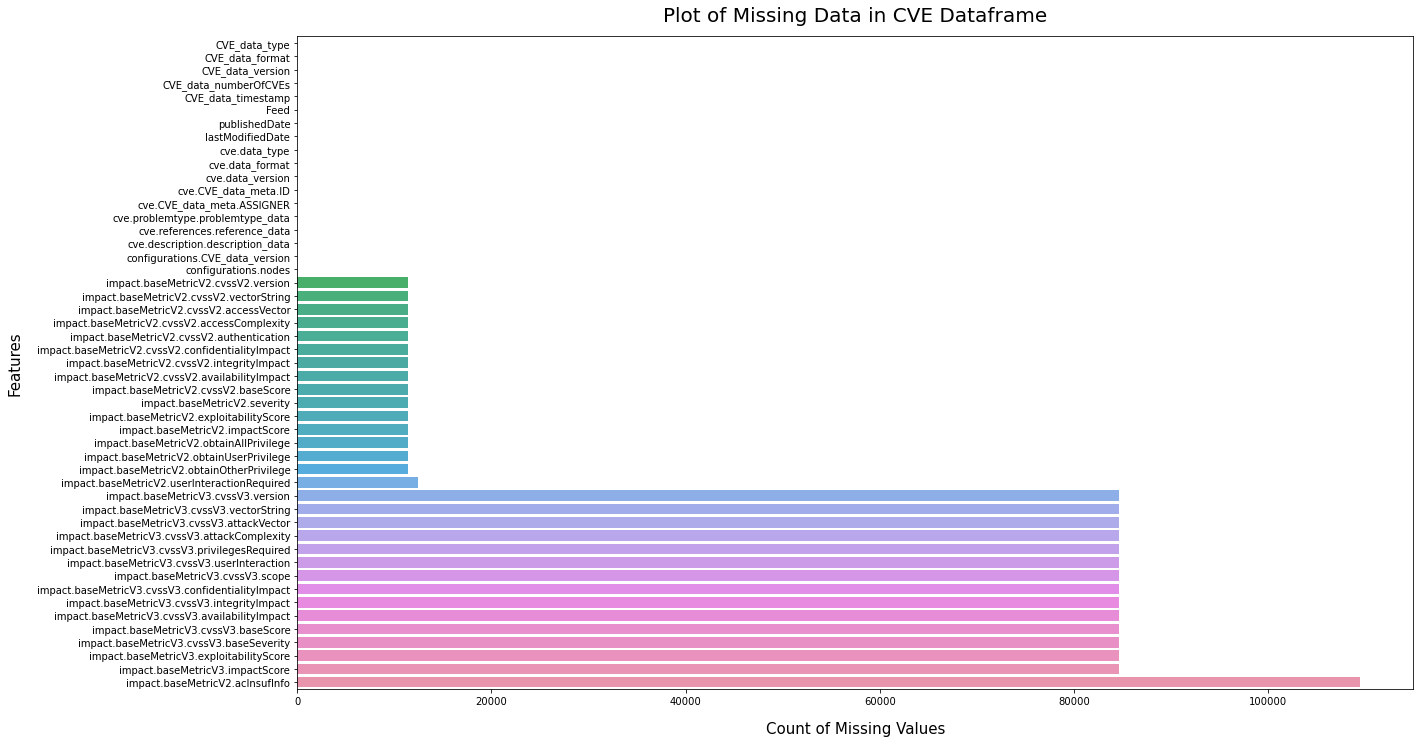

In [362]:
fig, ax = plt.subplots(figsize=(20, 12))
sns.barplot(x = df.isna().sum(), y =df.columns)
ax.set_title('Plot of Missing Data in CVE Dataframe', pad=15, size=20)
ax.set_ylabel('Features', labelpad=15, size=15)
ax.set_xlabel('Count of Missing Values', labelpad=15, size=15)

To check for duplicates in the data, I am checking the CVE ID feature for unique values.

In [363]:
df['cve.CVE_data_meta.ID'].describe()

count             184870
unique            184870
top       CVE-2018-12712
freq                   1
Name: cve.CVE_data_meta.ID, dtype: object

The count of unique ID's in the dataframe matches the number of rows, indicating there is one row per CVE ID.

In [364]:
df['cve.problemtype.problemtype_data']

0         [{'description': [{'lang': 'en', 'value': 'CWE...
1         [{'description': [{'lang': 'en', 'value': 'CWE...
2         [{'description': [{'lang': 'en', 'value': 'NVD...
3         [{'description': [{'lang': 'en', 'value': 'NVD...
4         [{'description': [{'lang': 'en', 'value': 'NVD...
                                ...                        
184865                                [{'description': []}]
184866                                [{'description': []}]
184867                                [{'description': []}]
184868                                [{'description': []}]
184869                                [{'description': []}]
Name: cve.problemtype.problemtype_data, Length: 184870, dtype: object

In [365]:
df['cve.references.reference_data']

0         [{'url': 'http://www.openbsd.org/errata23.html...
1         [{'url': 'http://www.securityfocus.com/bid/121...
2         [{'url': 'ftp://patches.sgi.com/support/free/s...
3         [{'url': 'https://docs.microsoft.com/en-us/sec...
4         [{'url': 'http://sunsolve.sun.com/pub-cgi/retr...
                                ...                        
184865    [{'url': 'https://github.com/barneycarroll/npm...
184866    [{'url': 'https://github.com/torvalds/linux/co...
184867    [{'url': 'https://github.com/sartlabs/0days/bl...
184868    [{'url': 'https://github.com/notable/notable-i...
184869    [{'url': 'https://devnet.kentico.com/download/...
Name: cve.references.reference_data, Length: 184870, dtype: object

Some features contain lists and dictionaries, for which the nunique method is unhashable. For this reason, I am creating a new dataframe with these columns dropped.

In [366]:
unhashable_cols = ['cve.problemtype.problemtype_data',
                   'cve.references.reference_data',
                   'cve.description.description_data',
                   'configurations.nodes']

df2 = df.drop(columns= unhashable_cols)

In [367]:
df2.nunique()

CVE_data_type                                            1
CVE_data_format                                          1
CVE_data_version                                         1
CVE_data_numberOfCVEs                                   21
CVE_data_timestamp                                      11
Feed                                                    21
publishedDate                                        23413
lastModifiedDate                                     68762
cve.data_type                                            1
cve.data_format                                          1
cve.data_version                                         1
cve.CVE_data_meta.ID                                184870
cve.CVE_data_meta.ASSIGNER                             196
configurations.CVE_data_version                          1
impact.baseMetricV2.cvssV2.version                       1
impact.baseMetricV2.cvssV2.vectorString                360
impact.baseMetricV2.cvssV2.accessVector                 

I'm now going to drop all columns with only 1 unique value, as they will not be useful in this analysis. 

In [368]:
df2 = df2.drop(columns=['CVE_data_type',
                        'CVE_data_format',
                        'CVE_data_version',
                        'cve.data_type',
                        'cve.data_format',
                        'cve.data_version',
                        'configurations.CVE_data_version',
                        'impact.baseMetricV2.cvssV2.version'])

Rejoining the unhashable columns.

In [369]:
df2 = df2.join(df[unhashable_cols])

In [370]:
df2

,CVE_data_numberOfCVEs,CVE_data_timestamp,Feed,publishedDate,lastModifiedDate,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,impact.baseMetricV2.cvssV2.vectorString,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.severity,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,impact.baseMetricV2.acInsufInfo,cve.problemtype.problemtype_data,cve.references.reference_data,cve.description.description_data,configurations.nodes
0,6769,2022-02-23T08:01Z,2002,1999-12-30T05:00Z,2010-12-16T05:00Z,CVE-1999-0001,cve@mitre.org,AV:N/AC:L/Au:N/C:N/I:N/A:P,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,5.0,MEDIUM,10.0,2.9,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.openbsd.org/errata23.html...,"[{'lang': 'en', 'value': 'ip_input.c in BSD-de...","[{'operator': 'OR', 'children': [], 'cpe_match..."
1,6769,2022-02-23T08:01Z,2002,1998-10-12T04:00Z,2009-01-26T05:00Z,CVE-1999-0002,cve@mitre.org,AV:N/AC:L/Au:N/C:C/I:C/A:C,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securityfocus.com/bid/121...,"[{'lang': 'en', 'value': 'Buffer overflow in N...","[{'operator': 'OR', 'children': [], 'cpe_match..."
2,6769,2022-02-23T08:01Z,2002,1998-04-01T05:00Z,2018-10-30T16:26Z,CVE-1999-0003,cve@mitre.org,AV:N/AC:L/Au:N/C:C/I:C/A:C,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'ftp://patches.sgi.com/support/free/s...,"[{'lang': 'en', 'value': 'Execute commands as ...","[{'operator': 'OR', 'children': [], 'cpe_match..."
3,6769,2022-02-23T08:01Z,2002,1997-12-16T05:00Z,2018-10-12T21:29Z,CVE-1999-0004,cve@mitre.org,AV:N/AC:L/Au:N/C:N/I:N/A:P,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,5.0,MEDIUM,10.0,2.9,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'https://docs.microsoft.com/en-us/sec...,"[{'lang': 'en', 'value': 'MIME buffer overflow...","[{'operator': 'OR', 'children': [], 'cpe_match..."
4,6769,2022-02-23T08:01Z,2002,1998-07-20T04:00Z,2008-09-09T12:33Z,CVE-1999-0005,cve@mitre.org,AV:N/AC:L/Au:N/C:C/I:C/A:C,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'http://sunsolve.sun.com/pub-cgi/retr...,"[{'lang': 'en', 'value': 'Arbitrary command ex...","[{'operator': 'OR', 'children': [], 'cpe_match..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184865,4163,2022-04-16T07:00Z

Examining columns with complex data.

In [371]:
pd.options.display.max_colwidth = 100

In [372]:
df2['cve.problemtype.problemtype_data'][0]

[{'description': [{'lang': 'en', 'value': 'CWE-20'}]}]

In [373]:
df2['cve.references.reference_data'][0]

[{'url': 'http://www.openbsd.org/errata23.html#tcpfix',
  'name': 'http://www.openbsd.org/errata23.html#tcpfix',
  'refsource': 'CONFIRM',
  'tags': []},
 {'url': 'http://www.osvdb.org/5707',
  'name': '5707',
  'refsource': 'OSVDB',
  'tags': []}]

In [374]:
df2['configurations.nodes'][0]

[{'operator': 'OR',
  'children': [],
  'cpe_match': [{'vulnerable': True,
    'cpe23Uri': 'cpe:2.3:o:freebsd:freebsd:1.0:*:*:*:*:*:*:*',
    'cpe_name': []},
   {'vulnerable': True,
    'cpe23Uri': 'cpe:2.3:o:freebsd:freebsd:1.1.5.1:*:*:*:*:*:*:*',
    'cpe_name': []},
   {'vulnerable': True,
    'cpe23Uri': 'cpe:2.3:o:freebsd:freebsd:2.1.7:*:*:*:*:*:*:*',
    'cpe_name': []},
   {'vulnerable': True,
    'cpe23Uri': 'cpe:2.3:o:freebsd:freebsd:2.2:*:*:*:*:*:*:*',
    'cpe_name': []},
   {'vulnerable': True,
    'cpe23Uri': 'cpe:2.3:o:freebsd:freebsd:2.2.8:*:*:*:*:*:*:*',
    'cpe_name': []},
   {'vulnerable': True,
    'cpe23Uri': 'cpe:2.3:o:openbsd:openbsd:2.3:*:*:*:*:*:*:*',
    'cpe_name': []},
   {'vulnerable': True,
    'cpe23Uri': 'cpe:2.3:o:bsdi:bsd_os:3.1:*:*:*:*:*:*:*',
    'cpe_name': []},
   {'vulnerable': True,
    'cpe23Uri': 'cpe:2.3:o:freebsd:freebsd:2.2.3:*:*:*:*:*:*:*',
    'cpe_name': []},
   {'vulnerable': True,
    'cpe23Uri': 'cpe:2.3:o:freebsd:freebsd:2.2.4:*:*:*:

In [375]:
df2['cve.description.description_data'][0]

[{'lang': 'en',
  'value': 'ip_input.c in BSD-derived TCP/IP implementations allows remote attackers to cause a denial of service (crash or hang) via crafted packets.'}]

For now I am going to leave these columns as they are without unpacking, to return to later if needed.

In [376]:
pd.reset_option('display.max_colwidth')

## Counting CVE's with CVSSv2 and CVSSv3 metrics.

In [377]:
cvssV2_vectors = df['impact.baseMetricV2.cvssV2.vectorString'].count()
cvssV2_vectors

173504

In [378]:
df['impact.baseMetricV2.cvssV2.confidentialityImpact'].count()

173504

In [379]:
df['impact.baseMetricV2.cvssV2.confidentialityImpact'].count()

173504

In [380]:
cvssV3_vectors = df['impact.baseMetricV3.cvssV3.vectorString'].count()
cvssV3_vectors

100265

In [381]:
df['impact.baseMetricV3.cvssV3.version'].count()

100265

In [382]:
df['impact.baseMetricV3.cvssV3.attackVector'].count()

100265

In [383]:
print(f'There are {cvssV2_vectors} CVE\'s with cvssV2 vectors.')

There are 173504 CVE's with cvssV2 vectors.


In [384]:
print(f'There are {cvssV3_vectors} CVE\'s with cvssV2 vectors.')

There are 100265 CVE's with cvssV2 vectors.


In [385]:
print(f'{(cvssV2_vectors + cvssV3_vectors) - len(df2)} CVE\'s have values for both')

88899 CVE's have values for both


## Mapping CVSSv2 Impact Metrics to CVSSv3

'The Confidentiality, Integrity and Availability impact metric values from v2.0 of None, Partial, and Complete have been replaced with None, Low, and High. Rather than representing the overall percentage (proportion) of the systems impacted by an attack, the new metric values reflect the overall degree of impact caused by an attack.' 

'...scoring vulnerabilities in CVSS v3.0, the Exploitability metrics are scored relative to the vulnerable component. That is, they are scored by considering the component that suffers the coding flaw. On the other hand, the Impact metrics are scored relative to the impacted component. In some cases, the vulnerable component may be the same as the impacted component, in which case, no scope change has occurred. However, in other cases, there may be an impact to the vulnerable component, as well as to the impacted component. In these cases, a scope change has occurred, and the Confidentiality, Integrity and Availability Impact metrics should reflect the impact to either the vulnerable component, or the impacted component, whichever is most severe.'

Source: https://www.first.org/cvss/v3.0/user-guide

As the CVSSv3 impact metrics consider scope and CVSSv2 do not, only CVSSv2 impact metrics for which scope is unchanged can be directly mapped to CVSSv3.

In [386]:
v2 = df2[['impact.baseMetricV2.cvssV2.confidentialityImpact', # creating dataframe of CVSSv2 impact metrics
                   'impact.baseMetricV2.cvssV2.integrityImpact',
                   'impact.baseMetricV2.cvssV2.availabilityImpact',
                   'impact.baseMetricV3.cvssV3.scope']].copy(deep=True)

v2.rename({'impact.baseMetricV2.cvssV2.confidentialityImpact':'ConfidentialityV2',
                     'impact.baseMetricV2.cvssV2.integrityImpact':'IntegrityV2',
                     'impact.baseMetricV2.cvssV2.availabilityImpact': 'AvailabilityV2',
                     'impact.baseMetricV3.cvssV3.scope': 'Scope'}, axis = 'columns', inplace=True)

v2

,ConfidentialityV2,IntegrityV2,AvailabilityV2,Scope
0,NONE,NONE,PARTIAL,NaN
1,COMPLETE,COMPLETE,COMPLETE,NaN
2,COMPLETE,COMPLETE,COMPLETE,NaN
3,NONE,NONE,PARTIAL,NaN
4,COMPLETE,COMPLETE,COMPLETE,NaN
...,...,...,...,...
184865,NaN,NaN,NaN,NaN
184866,NaN,NaN,NaN,NaN
184867,NaN,NaN,NaN,NaN
184868,NaN,NaN,NaN,NaN


In [387]:
v2.Scope.value_counts() # examining scope variable

UNCHANGED    83354
CHANGED      16911
Name: Scope, dtype: int64

To map CVSSv2 to CVSSv3 impact metrics, I am selecting only the impact metrics for which the scope is 'UNCHANGED'.

In [388]:
mask1 = v2['ConfidentialityV2'].notnull() # selecting Confidentiality values that are not null

mask2 = v2['Scope'] == 'UNCHANGED' # selecting scope values that are unchanged

v2.loc[mask1 & mask2] # locating rows

,ConfidentialityV2,IntegrityV2,AvailabilityV2,Scope
198,PARTIAL,PARTIAL,PARTIAL,UNCHANGED
235,PARTIAL,NONE,NONE,UNCHANGED
1836,NONE,NONE,PARTIAL,UNCHANGED
2820,PARTIAL,NONE,NONE,UNCHANGED
6322,NONE,NONE,PARTIAL,UNCHANGED
...,...,...,...,...
184817,PARTIAL,PARTIAL,PARTIAL,UNCHANGED
184839,COMPLETE,COMPLETE,COMPLETE,UNCHANGED
184840,PARTIAL,NONE,PARTIAL,UNCHANGED
184844,COMPLETE,COMPLETE,COMPLETE,UNCHANGED


While selecting only the metrics whose scope is unchanged, I can directly map their CVSSv2 values of (NONE, PARTIAL, COMPLETE) to CVSSv3 equivalents (NONE, LOW, HIGH).

In [389]:
ConfidentialityV3 = v2.loc[mask1 & mask2]['ConfidentialityV2'] # selecting confidentiality metric with scope unchanged

ConfidentialityV3 = pd.DataFrame(ConfidentialityV3)

ConfidentialityV3.rename(columns={'ConfidentialityV2':'ConfidentialityV3'}, inplace=True) # renaming 

ConfidentialityV3.replace(to_replace = ['NONE', 'PARTIAL', 'COMPLETE'], value= ['NONE','LOW', 'HIGH'], inplace=True) # replacing values

v2 = pd.concat([v2, ConfidentialityV3], axis=1).fillna(np.NaN) # joining new column to dataframe

v2.loc[mask1 & mask2]

,ConfidentialityV2,IntegrityV2,AvailabilityV2,Scope,ConfidentialityV3
198,PARTIAL,PARTIAL,PARTIAL,UNCHANGED,LOW
235,PARTIAL,NONE,NONE,UNCHANGED,LOW
1836,NONE,NONE,PARTIAL,UNCHANGED,NONE
2820,PARTIAL,NONE,NONE,UNCHANGED,LOW
6322,NONE,NONE,PARTIAL,UNCHANGED,NONE
...,...,...,...,...,...
184817,PARTIAL,PARTIAL,PARTIAL,UNCHANGED,LOW
184839,COMPLETE,COMPLETE,COMPLETE,UNCHANGED,HIGH
184840,PARTIAL,NONE,PARTIAL,UNCHANGED,LOW
184844,COMPLETE,COMPLETE,COMPLETE,UNCHANGED,HIGH


In [390]:
v2.loc[mask1 & mask2]['ConfidentialityV2'].value_counts()

PARTIAL     47637
NONE        21016
COMPLETE    14589
Name: ConfidentialityV2, dtype: int64

In [391]:
v2.loc[mask1 & mask2]['ConfidentialityV3'].value_counts()

LOW     47637
NONE    21016
HIGH    14589
Name: ConfidentialityV3, dtype: int64

We now have the CVSSv3 Confidentiality metric values where the scope is unchanged. This process can be repeated for Integrity and Availability metrics.

In [392]:
mask3 = v2['IntegrityV2'].notnull() # selecting Integrity values

IntegrityV3 = v2.loc[mask2 & mask3]['IntegrityV2'] 
IntegrityV3 = pd.DataFrame(IntegrityV3)
IntegrityV3.rename(columns={'IntegrityV2':'IntegrityV3'}, inplace=True) 
IntegrityV3.replace(to_replace = ['NONE', 'PARTIAL', 'COMPLETE'], value= ['NONE','LOW', 'HIGH'], inplace=True) 
v2 = pd.concat([v2, IntegrityV3], axis=1).fillna(np.NaN) 

In [393]:
mask4 = v2['AvailabilityV2'].notnull() # selecting availability values

AvailabilityV3 = v2.loc[mask2 & mask4]['AvailabilityV2'] 
AvailabilityV3 = pd.DataFrame(AvailabilityV3)
AvailabilityV3.rename(columns={'AvailabilityV2':'AvailabilityV3'}, inplace=True) 
AvailabilityV3.replace(to_replace = ['NONE', 'PARTIAL', 'COMPLETE'], value= ['NONE','LOW', 'HIGH'], inplace=True) 

v2 = pd.concat([v2, AvailabilityV3], axis=1).fillna(np.NaN) 

In [394]:
v2.loc[mask2]

,ConfidentialityV2,IntegrityV2,AvailabilityV2,Scope,ConfidentialityV3,IntegrityV3,AvailabilityV3
198,PARTIAL,PARTIAL,PARTIAL,UNCHANGED,LOW,LOW,LOW
235,PARTIAL,NONE,NONE,UNCHANGED,LOW,NONE,NONE
1836,NONE,NONE,PARTIAL,UNCHANGED,NONE,NONE,LOW
2820,PARTIAL,NONE,NONE,UNCHANGED,LOW,NONE,NONE
6322,NONE,NONE,PARTIAL,UNCHANGED,NONE,NONE,LOW
...,...,...,...,...,...,...,...
184817,PARTIAL,PARTIAL,PARTIAL,UNCHANGED,LOW,LOW,LOW
184839,COMPLETE,COMPLETE,COMPLETE,UNCHANGED,HIGH,HIGH,HIGH
184840,PARTIAL,NONE,PARTIAL,UNCHANGED,LOW,NONE,LOW
184844,COMPLETE,COMPLETE,COMPLETE,UNCHANGED,HIGH,HIGH,HIGH


In [395]:
v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184870 entries, 0 to 184869
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ConfidentialityV2  173504 non-null  object
 1   IntegrityV2        173504 non-null  object
 2   AvailabilityV2     173504 non-null  object
 3   Scope              100265 non-null  object
 4   ConfidentialityV3  83242 non-null   object
 5   IntegrityV3        83242 non-null   object
 6   AvailabilityV3     83242 non-null   object
dtypes: object(7)
memory usage: 11.3+ MB


In [396]:
v2.loc[mask1 & mask2]['IntegrityV2'].value_counts()

PARTIAL     37381
NONE        31598
COMPLETE    14263
Name: IntegrityV2, dtype: int64

In [397]:
v2.loc[mask1 & mask2]['IntegrityV3'].value_counts()

LOW     37381
NONE    31598
HIGH    14263
Name: IntegrityV3, dtype: int64

In [398]:
v2.loc[mask1 & mask2]['AvailabilityV2'].value_counts()

PARTIAL     40560
NONE        25583
COMPLETE    17099
Name: AvailabilityV2, dtype: int64

In [399]:
v2.loc[mask1 & mask2]['AvailabilityV3'].value_counts()

LOW     40560
NONE    25583
HIGH    17099
Name: AvailabilityV3, dtype: int64

## Predicting CVSSv3 Scope for CVEs without CVSSv3 vector.

In [400]:
df2['impact.baseMetricV3.cvssV3.scope'].value_counts()

UNCHANGED    83354
CHANGED      16911
Name: impact.baseMetricV3.cvssV3.scope, dtype: int64

Unchanged - Exploited component and vulnerable component are the same.

Changed - Exploited component and vulnerable component are the different.

I am first going to build a model to try and predict the scope of CVEs with a scope variable, this being our labelled data. If the model is succesuccessful I can then adapt it to the unlabelled CVSSv2 data.

In [401]:
df2

,CVE_data_numberOfCVEs,CVE_data_timestamp,Feed,publishedDate,lastModifiedDate,cve.CVE_data_meta.ID,cve.CVE_data_meta.ASSIGNER,impact.baseMetricV2.cvssV2.vectorString,impact.baseMetricV2.cvssV2.accessVector,impact.baseMetricV2.cvssV2.accessComplexity,impact.baseMetricV2.cvssV2.authentication,impact.baseMetricV2.cvssV2.confidentialityImpact,impact.baseMetricV2.cvssV2.integrityImpact,impact.baseMetricV2.cvssV2.availabilityImpact,impact.baseMetricV2.cvssV2.baseScore,impact.baseMetricV2.severity,impact.baseMetricV2.exploitabilityScore,impact.baseMetricV2.impactScore,impact.baseMetricV2.obtainAllPrivilege,impact.baseMetricV2.obtainUserPrivilege,impact.baseMetricV2.obtainOtherPrivilege,impact.baseMetricV2.userInteractionRequired,impact.baseMetricV3.cvssV3.version,impact.baseMetricV3.cvssV3.vectorString,impact.baseMetricV3.cvssV3.attackVector,impact.baseMetricV3.cvssV3.attackComplexity,impact.baseMetricV3.cvssV3.privilegesRequired,impact.baseMetricV3.cvssV3.userInteraction,impact.baseMetricV3.cvssV3.scope,impact.baseMetricV3.cvssV3.confidentialityImpact,impact.baseMetricV3.cvssV3.integrityImpact,impact.baseMetricV3.cvssV3.availabilityImpact,impact.baseMetricV3.cvssV3.baseScore,impact.baseMetricV3.cvssV3.baseSeverity,impact.baseMetricV3.exploitabilityScore,impact.baseMetricV3.impactScore,impact.baseMetricV2.acInsufInfo,cve.problemtype.problemtype_data,cve.references.reference_data,cve.description.description_data,configurations.nodes
0,6769,2022-02-23T08:01Z,2002,1999-12-30T05:00Z,2010-12-16T05:00Z,CVE-1999-0001,cve@mitre.org,AV:N/AC:L/Au:N/C:N/I:N/A:P,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,5.0,MEDIUM,10.0,2.9,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.openbsd.org/errata23.html...,"[{'lang': 'en', 'value': 'ip_input.c in BSD-de...","[{'operator': 'OR', 'children': [], 'cpe_match..."
1,6769,2022-02-23T08:01Z,2002,1998-10-12T04:00Z,2009-01-26T05:00Z,CVE-1999-0002,cve@mitre.org,AV:N/AC:L/Au:N/C:C/I:C/A:C,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'description': [{'lang': 'en', 'value': 'CWE...",[{'url': 'http://www.securityfocus.com/bid/121...,"[{'lang': 'en', 'value': 'Buffer overflow in N...","[{'operator': 'OR', 'children': [], 'cpe_match..."
2,6769,2022-02-23T08:01Z,2002,1998-04-01T05:00Z,2018-10-30T16:26Z,CVE-1999-0003,cve@mitre.org,AV:N/AC:L/Au:N/C:C/I:C/A:C,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'ftp://patches.sgi.com/support/free/s...,"[{'lang': 'en', 'value': 'Execute commands as ...","[{'operator': 'OR', 'children': [], 'cpe_match..."
3,6769,2022-02-23T08:01Z,2002,1997-12-16T05:00Z,2018-10-12T21:29Z,CVE-1999-0004,cve@mitre.org,AV:N/AC:L/Au:N/C:N/I:N/A:P,NETWORK,LOW,NONE,NONE,NONE,PARTIAL,5.0,MEDIUM,10.0,2.9,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'https://docs.microsoft.com/en-us/sec...,"[{'lang': 'en', 'value': 'MIME buffer overflow...","[{'operator': 'OR', 'children': [], 'cpe_match..."
4,6769,2022-02-23T08:01Z,2002,1998-07-20T04:00Z,2008-09-09T12:33Z,CVE-1999-0005,cve@mitre.org,AV:N/AC:L/Au:N/C:C/I:C/A:C,NETWORK,LOW,NONE,COMPLETE,COMPLETE,COMPLETE,10.0,HIGH,10.0,10.0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'description': [{'lang': 'en', 'value': 'NVD...",[{'url': 'http://sunsolve.sun.com/pub-cgi/retr...,"[{'lang': 'en', 'value': 'Arbitrary command ex...","[{'operator': 'OR', 'children': [], 'cpe_match..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184865,4163,2022-04-16T07:00Z

To try and predict scope, I am going to select relevant CVSSv3 metrics to use as independent variables. I am then going to drop any missing values.

In [402]:
CVSSv3 = df2[['impact.baseMetricV3.cvssV3.scope', # selecting features to use 
    'impact.baseMetricV3.cvssV3.attackVector',
    'impact.baseMetricV3.cvssV3.attackComplexity',
    'impact.baseMetricV3.cvssV3.privilegesRequired',
    'impact.baseMetricV3.cvssV3.userInteraction',
    'impact.baseMetricV3.cvssV3.confidentialityImpact',
    'impact.baseMetricV3.cvssV3.integrityImpact',
    'impact.baseMetricV3.cvssV3.availabilityImpact',
    'impact.baseMetricV3.cvssV3.baseScore',
    'impact.baseMetricV3.cvssV3.baseSeverity',
    'impact.baseMetricV3.exploitabilityScore',
    'impact.baseMetricV3.impactScore'
    ]].copy()

CVSSv3.rename({'impact.baseMetricV3.cvssV3.scope':'cvssV3.scope', # renaming
    'impact.baseMetricV3.cvssV3.attackVector':'cvssV3.attackVector',
    'impact.baseMetricV3.cvssV3.attackComplexity':'cvssV3.attackComplexity',
    'impact.baseMetricV3.cvssV3.privilegesRequired':'cvssV3.privilegesRequired',
    'impact.baseMetricV3.cvssV3.userInteraction':'cvssV3.userInteraction',
    'impact.baseMetricV3.cvssV3.confidentialityImpact':'cvssV3.confidentialityImpact',
    'impact.baseMetricV3.cvssV3.integrityImpact':'cvssV3.integrityImpact',
    'impact.baseMetricV3.cvssV3.availabilityImpact':'cvssV3.availabilityImpact',
    'impact.baseMetricV3.cvssV3.baseScore':'cvssV3.baseScore',
    'impact.baseMetricV3.cvssV3.baseSeverity':'cvssV3.baseSeverity',
    'impact.baseMetricV3.exploitabilityScore':'cvssV3.exploitabilityScore',
    'impact.baseMetricV3.impactScore':'CVSSV3impactScore'}, axis = 'columns', inplace=True)

CVSSv3.dropna(inplace=True) # dropping missing values
CVSSv3.reset_index(drop=True, inplace=True)

In [403]:
CVSSv3

,cvssV3.scope,cvssV3.attackVector,cvssV3.attackComplexity,cvssV3.privilegesRequired,cvssV3.userInteraction,cvssV3.confidentialityImpact,cvssV3.integrityImpact,cvssV3.availabilityImpact,cvssV3.baseScore,cvssV3.baseSeverity,cvssV3.exploitabilityScore,CVSSV3impactScore
0,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9
1,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,7.5,HIGH,3.9,3.6
2,UNCHANGED,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,7.5,HIGH,3.9,3.6
3,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,7.5,HIGH,3.9,3.6
4,UNCHANGED,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,7.5,HIGH,3.9,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...
100260,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9
100261,UNCHANGED,LOCAL,HIGH,LOW,NONE,HIGH,HIGH,HIGH,7.0,HIGH,1.0,5.9
100262,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,NONE,HIGH,9.1,CRITICAL,3.9,5.2
100263,UNCHANGED,LOCAL,LOW,LOW,NONE,HIGH,HIGH,HIGH,7.8,HIGH,1.8,5.9


To prepare the data for use in a classification algorithm, I am going to encode the data using the sklearn label encoder module.

In [404]:
le = preprocessing.LabelEncoder() 
CVSSv3_enc = CVSSv3.apply(le.fit_transform) # applying label encoder label encoder

CVSSv3_enc

,cvssV3.scope,cvssV3.attackVector,cvssV3.attackComplexity,cvssV3.privilegesRequired,cvssV3.userInteraction,cvssV3.confidentialityImpact,cvssV3.integrityImpact,cvssV3.availabilityImpact,cvssV3.baseScore,cvssV3.baseSeverity,cvssV3.exploitabilityScore,CVSSV3impactScore
0,1,2,1,2,0,0,0,0,77,0,25,13
1,1,2,1,2,0,0,2,2,57,1,25,4
2,1,2,1,2,0,2,2,0,57,1,25,4
3,1,2,1,2,0,0,2,2,57,1,25,4
4,1,2,1,2,0,2,2,0,57,1,25,4
...,...,...,...,...,...,...,...,...,...,...,...,...
100260,1,2,1,2,0,0,0,0,77,0,25,13
100261,1,1,0,1,0,0,0,0,52,1,9,13
100262,1,2,1,2,0,0,2,0,73,0,25,9
100263,1,1,1,1,0,0,0,0,60,1,17,13


With the data now stored numerically, I can look at the Pearson correlation to get an idea of how each feature relates to the target scope variable

In [405]:
CVSSv3_enc.corr(method='pearson') # calling correlation 

,cvssV3.scope,cvssV3.attackVector,cvssV3.attackComplexity,cvssV3.privilegesRequired,cvssV3.userInteraction,cvssV3.confidentialityImpact,cvssV3.integrityImpact,cvssV3.availabilityImpact,cvssV3.baseScore,cvssV3.baseSeverity,cvssV3.exploitabilityScore,CVSSV3impactScore
cvssV3.scope,1.000000,-0.152499,-0.055964,0.100448,-0.443450,-0.150949,-0.071938,-0.417936,0.262301,-0.356871,-0.039631,0.339169
cvssV3.attackVector,-0.152499,1.000000,0.011044,0.194646,-0.024106,0.096216,0.059643,0.204690,0.109300,-0.057916,0.455667,-0.182542
cvssV3.attackComplexity,-0.055964,0.011044,1.000000,-0.020577,0.064246,0.051246,0.020269,0.015140,0.130050,-0.064611,0.326502,-0.048722
cvssV3.privilegesRequired,0.100448,0.194646,-0.020577,1.000000,0.224998,0.045857,0.028553,-0.031976,0.320414,-0.268562,0.608859,-0.009874
cvssV3.userInteraction,-0.443450,-0.024106,0.064246,0.224998,1.000000,0.067076,-0.028736,0.169834,-0.233608,0.332710,-0.094910,-0.143383
cvssV3.confidentialityImpact,-0.150949,0.096216,0.051246,0.045857,0.067076,1.000000,0.468549,0.203419,-0.542987,0.498886,0.105935,-0.688350
cvssV3.integrityImpact,-0.071938,0.059643,0.020269,0.028553,-0.028736,0.468549,1.000000,0.422634,-0.624846,0.559649,0.084683,-0.785070
cvssV3.availabilityImpact,-0.417936,0.204690,0.015140,-0.031976,0.169834,0.203419,0.422634,1.000000,-0.635103,0.602623,0.108371,-0.767003
cvssV3.baseScore,0.262301,0.109300,0.130050,0.320414,-0.233608,-0.542987,-0.624846,-0.635103,1.000000,-0.876556,0.394229,0.822763
cvssV3.baseSeverity,-0.356871,-0.057916,-0.064611,-0.268562,0.332710,0.498886,0.559649,0.602623,-0.876556,1.000000,-0.290964,-0.758427


<AxesSubplot:>

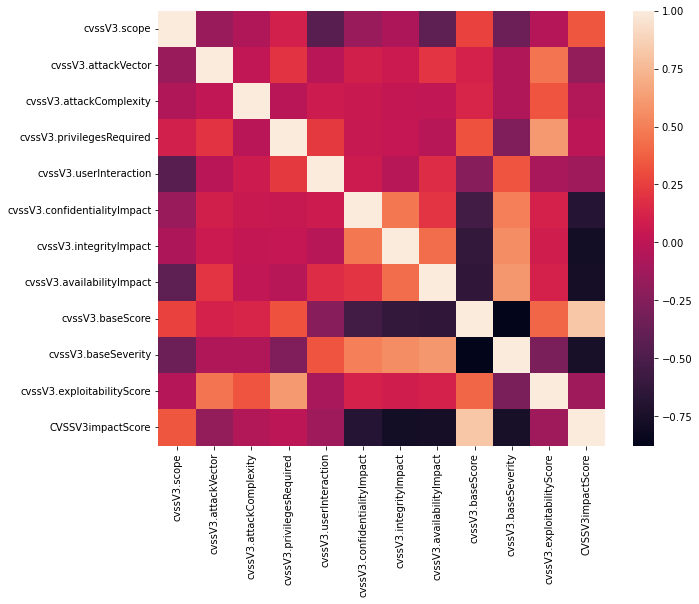

In [406]:
plt.figure(figsize=(10,8)) # visualizing correlation with heatmap
sns.heatmap(CVSSv3_enc.corr(method='pearson'))

From the correlation method, the features user-interaction, availability-impact and base-severity look to be the most correlated with scope.

The first model I am going to use to try and predict scope is a decision tree model. I chose this model as it is generally effective in classification tasks with a mix of categorical and continuous variables, and have simple and easy to understand logic. With an understanding of the branching in the decision tree, I can then improve upon the accuracy with more complex models later.

In [407]:
X = CVSSv3_enc.iloc[:, 1:] # independent variaable selection (all features except scope)
y = CVSSv3_enc[['cvssV3.scope']] # target variable selection (scope)

In [408]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1) # defining train/test split

In [409]:
DTC = DecisionTreeClassifier(max_depth = 10, random_state = 0) # calling decision tree classifier

DTC = DTC.fit(X_train, y_train) # fitting to data

y_pred = DTC.predict(X_test) 
accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy is: {accuracy}% with a train/test split of 70/30.")

The model accuacy is: 99.914% with a train/test split of 70/30.


The decision tree model looks to be very effective with predicting the scope based on CVSSv3 metrics. To try and improve the accuracy further, I am going to experiment with different train/test splits.

In [410]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1) # setting train/test split to 90/10
y_pred = DTC.predict(X_test)
accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)
print(f"The model accuacy is: {accuracy}% with a train/test split of 90/10.")

The model accuacy is: 99.9% with a train/test split of 90/10.


In [411]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 1) # setting train/test split to 95/15
y_pred = DTC.predict(X_test)
accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)
print(f"The model accuacy is: {accuracy}% with a train/test split of 95/5.")

The model accuacy is: 99.88% with a train/test split of 95/5.


All of the test splits returned a model accuracy of over 99%, with train/test split of 70/30 or 95/5 having the highest. To maximise the training data, I am going to use a split of 70/30 for the rest of the models. 

A common issue with decision trees is that they are prone to overfitting. To use this model on unlabelled data I want to make it as generalizable as possible. To see if the model may be overfitting, I can check the feature importance’s DTC model.

In [412]:
feature_imp = pd.Series(DTC.feature_importances_, index = X.columns).sort_values(ascending = False) # measuring feature importance
feature_imp

CVSSV3impactScore               0.954052
cvssV3.baseScore                0.029003
cvssV3.userInteraction          0.009412
cvssV3.attackComplexity         0.003433
cvssV3.exploitabilityScore      0.002764
cvssV3.privilegesRequired       0.001122
cvssV3.attackVector             0.000153
cvssV3.availabilityImpact       0.000059
cvssV3.confidentialityImpact    0.000000
cvssV3.integrityImpact          0.000000
cvssV3.baseSeverity             0.000000
dtype: float64

The feature 'impact-score' has a feature importance score of 95%, indicating the model is heavily reliant on this one feature and is likely overfitting. 

To combat this issue, I am going to implement a random forest classifier.

In [413]:
RFC = RandomForestClassifier(n_estimators = 100, random_state=0) # calling random forest classifier

RFC.fit(X_train, y_train) # fitting to data

y_pred = RFC.predict(X_test)

accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy is: {accuracy}% with Random Forest Classification.")

The model accuacy is: 99.94% with Random Forest Classification.


The random forest classification model improved the accuracy to 99 - 100%. To check for overfitting, I'll again look at the feature importance’s.

In [414]:
feature_imp = pd.Series(RFC.feature_importances_, index = X.columns).sort_values(ascending = False) # measuring feature importance
feature_imp

CVSSV3impactScore               0.417058
cvssV3.baseScore                0.166710
cvssV3.userInteraction          0.115237
cvssV3.integrityImpact          0.088857
cvssV3.confidentialityImpact    0.066002
cvssV3.exploitabilityScore      0.046531
cvssV3.availabilityImpact       0.046130
cvssV3.attackVector             0.021886
cvssV3.baseSeverity             0.020340
cvssV3.privilegesRequired       0.009782
cvssV3.attackComplexity         0.001468
dtype: float64

Comparing the feature importance’s of the RFC to the DTC, there is a much more even spread in importance with no one feature scoring above 50%. This is a good indication that the model less prone to overfitting and overly relying on one feature than the DTC. 

This does not mean that there is no overfitting with the RFC model. The generalization error variance for an RFC model decreases when more trees are added, however there is still bias from generalizing. To further test for this I would evaluate the model using k-fold cross validation. For the purposes of this analysis the model should be adequate as is. 

Text(0.5, 0, 'Importance (%)')

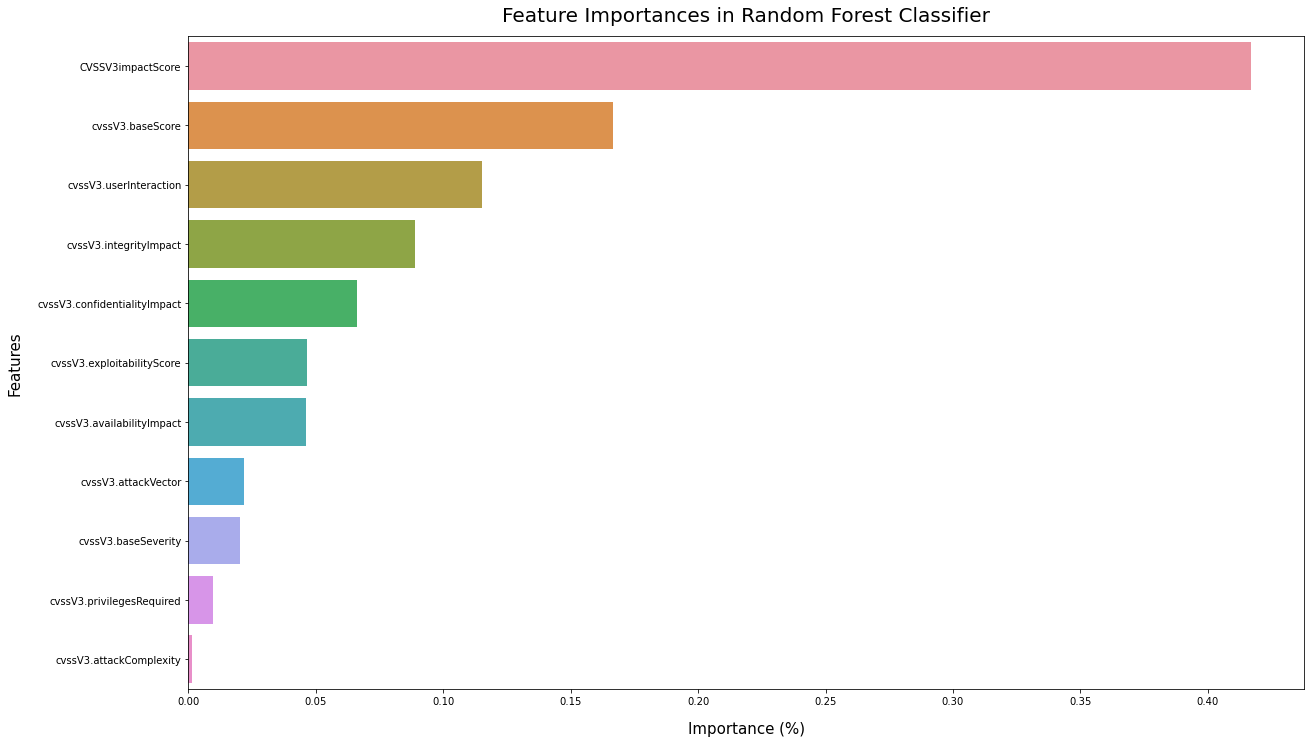

In [415]:
fig, ax = plt.subplots(figsize=(20, 12)) # plotting feature importance
sns.barplot(x = feature_imp, y = feature_imp.index)
ax.set_title('Feature Importances in Random Forest Classifier', pad=15, size=20)
ax.set_ylabel('Features', labelpad=15, size=15)
ax.set_xlabel('Importance (%)', labelpad=15, size=15)

With the random forest model proving to be effective at predicting scope for CVEs with CVSSv3 metrics, I am going to try and apply the same model to CVEs with CVSSv2 metrics.

To do so, I will use the CVSSv3 labelled data to train the model, and then apply it to the unlabelled CVSSv2 data.

The metrics for CVSSv2 are not in the same format as CVSSv3, so I will first need to prepare the data so the training and application datasets match. 

I am going to compare the values in each dataset, and check the documentation of both to ensure they are comparable. The previously mapped impact metrics could have been used for this, only they were only mapped for 'UNCHANGED' values. Mapping each of the categorical variables may be avoided, if the continuous variables have enough classification power.

Source:

https://www.first.org/cvss/v2/guide

https://www.first.org/cvss/specification-document

In [416]:
CVSSv2 = df[['impact.baseMetricV2.cvssV2.baseScore',
             'impact.baseMetricV2.exploitabilityScore',
             'impact.baseMetricV2.impactScore'
    ]].copy()

CVSSv2.rename({'impact.baseMetricV2.cvssV2.baseScore':'cvssV2.baseScore',
    'impact.baseMetricV2.exploitabilityScore':'cvssV2.exploitabilityScore',
    'impact.baseMetricV2.impactScore':'cvssV2.impactScore'}, axis = 'columns', inplace=True)

CVSSv2.dropna(inplace=True) # dropping missing values
CVSSv2.reset_index(drop=True, inplace=True)

CVSSv2

,cvssV2.baseScore,cvssV2.exploitabilityScore,cvssV2.impactScore
0,5.0,10.0,2.9
1,10.0,10.0,10.0
2,10.0,10.0,10.0
3,5.0,10.0,2.9
4,10.0,10.0,10.0
...,...,...,...
173499,7.5,10.0,6.4
173500,6.9,3.4,10.0
173501,6.4,10.0,4.9
173502,7.2,3.9,10.0


In [417]:
CVSSv3

,cvssV3.scope,cvssV3.attackVector,cvssV3.attackComplexity,cvssV3.privilegesRequired,cvssV3.userInteraction,cvssV3.confidentialityImpact,cvssV3.integrityImpact,cvssV3.availabilityImpact,cvssV3.baseScore,cvssV3.baseSeverity,cvssV3.exploitabilityScore,CVSSV3impactScore
0,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9
1,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,7.5,HIGH,3.9,3.6
2,UNCHANGED,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,7.5,HIGH,3.9,3.6
3,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,7.5,HIGH,3.9,3.6
4,UNCHANGED,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,7.5,HIGH,3.9,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...
100260,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,9.8,CRITICAL,3.9,5.9
100261,UNCHANGED,LOCAL,HIGH,LOW,NONE,HIGH,HIGH,HIGH,7.0,HIGH,1.0,5.9
100262,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,NONE,HIGH,9.1,CRITICAL,3.9,5.2
100263,UNCHANGED,LOCAL,LOW,LOW,NONE,HIGH,HIGH,HIGH,7.8,HIGH,1.8,5.9


For the continuous variables, I will use a MinMax scaler to normalize the data.

In [418]:
scaler = MinMaxScaler()
scaler.fit(CVSSv2[['cvssV2.baseScore', 'cvssV2.exploitabilityScore', 'cvssV2.impactScore']])
scaled = scaler.fit_transform(CVSSv2[['cvssV2.baseScore', 'cvssV2.exploitabilityScore', 'cvssV2.impactScore']])
scaled_df = pd.DataFrame(scaled, columns=[['cvssV2.baseScore', 'cvssV2.exploitabilityScore', 'cvssV2.impactScore']])
CVSSv2[['cvssV2.baseScore', 'cvssV2.exploitabilityScore', 'cvssV2.impactScore']] = scaled_df
CVSSv2

,cvssV2.baseScore,cvssV2.exploitabilityScore,cvssV2.impactScore
0,0.50,1.000000,0.29
1,1.00,1.000000,1.00
2,1.00,1.000000,1.00
3,0.50,1.000000,0.29
4,1.00,1.000000,1.00
...,...,...,...
173499,0.75,1.000000,0.64
173500,0.69,0.250000,1.00
173501,0.64,1.000000,0.49
173502,0.72,0.306818,1.00


In [419]:
scaler.fit(CVSSv3[['cvssV3.baseScore', 'cvssV3.exploitabilityScore', 'CVSSV3impactScore']])
scaled = scaler.fit_transform(CVSSv3[['cvssV3.baseScore', 'cvssV3.exploitabilityScore', 'CVSSV3impactScore']])
scaled_df = pd.DataFrame(scaled, columns=[['cvssV3.baseScore', 'cvssV3.exploitabilityScore', 'CVSSV3impactScore']])
CVSSv3[['cvssV3.baseScore', 'cvssV3.exploitabilityScore', 'CVSSV3impactScore']] = scaled_df
CVSSv3


,cvssV3.scope,cvssV3.attackVector,cvssV3.attackComplexity,cvssV3.privilegesRequired,cvssV3.userInteraction,cvssV3.confidentialityImpact,cvssV3.integrityImpact,cvssV3.availabilityImpact,cvssV3.baseScore,cvssV3.baseSeverity,cvssV3.exploitabilityScore,CVSSV3impactScore
0,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,0.975610,CRITICAL,1.000000,0.978261
1,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,0.695122,HIGH,1.000000,0.478261
2,UNCHANGED,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,0.695122,HIGH,1.000000,0.478261
3,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,NONE,NONE,0.695122,HIGH,1.000000,0.478261
4,UNCHANGED,NETWORK,LOW,NONE,NONE,NONE,NONE,HIGH,0.695122,HIGH,1.000000,0.478261
...,...,...,...,...,...,...,...,...,...,...,...,...
100260,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,HIGH,HIGH,0.975610,CRITICAL,1.000000,0.978261
100261,UNCHANGED,LOCAL,HIGH,LOW,NONE,HIGH,HIGH,HIGH,0.634146,HIGH,0.236842,0.978261
100262,UNCHANGED,NETWORK,LOW,NONE,NONE,HIGH,NONE,HIGH,0.890244,CRITICAL,1.000000,0.826087
100263,UNCHANGED,LOCAL,LOW,LOW,NONE,HIGH,HIGH,HIGH,0.731707,HIGH,0.447368,0.978261


With the data normalized in both datasets.

I am going to again use the random forest classifier, this time on the new normalized data.

In [420]:
CVSSv3_train = CVSSv3[['cvssV3.scope', 'cvssV3.baseScore', 'cvssV3.exploitabilityScore', 'CVSSV3impactScore']] 
CVSSv3_train

,cvssV3.scope,cvssV3.baseScore,cvssV3.exploitabilityScore,CVSSV3impactScore
0,UNCHANGED,0.975610,1.000000,0.978261
1,UNCHANGED,0.695122,1.000000,0.478261
2,UNCHANGED,0.695122,1.000000,0.478261
3,UNCHANGED,0.695122,1.000000,0.478261
4,UNCHANGED,0.695122,1.000000,0.478261
...,...,...,...,...
100260,UNCHANGED,0.975610,1.000000,0.978261
100261,UNCHANGED,0.634146,0.236842,0.978261
100262,UNCHANGED,0.890244,1.000000,0.826087
100263,UNCHANGED,0.731707,0.447368,0.978261


In [421]:
le = preprocessing.LabelEncoder() 
CVSSv3_train = CVSSv3_train.apply(le.fit_transform) # applying label encoder label encoder
CVSSv3_train

,cvssV3.scope,cvssV3.baseScore,cvssV3.exploitabilityScore,CVSSV3impactScore
0,1,77,25,13
1,1,57,25,4
2,1,57,25,4
3,1,57,25,4
4,1,57,25,4
...,...,...,...,...
100260,1,77,25,13
100261,1,52,9,13
100262,1,73,25,9
100263,1,60,17,13


In [422]:
X = CVSSv3_train[['cvssV3.baseScore', 'cvssV3.exploitabilityScore', 'CVSSV3impactScore']] 
y = CVSSv3_train[['cvssV3.scope']] # target variable selection (scope)

In [423]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1) # defining train/test split

In [424]:
RFC = RandomForestClassifier(n_estimators = 100, random_state=0) # calling random forest classifier

RFC.fit(X_train, y_train) # fitting to data

y_pred = RFC.predict(X_test)

accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy is: {accuracy}% with Random Forest Classification.")

The model accuacy is: 100.0% with Random Forest Classification.


Using only the continuous features base-score, exploitability-score and impact-score the RFC model achieved accuracy of 100%. 

I can now use this model to predict the scope metric for CVEs with CVSSv2 metrics.

In [425]:
CVSSv2_pred = CVSSv2[['cvssV2.baseScore', 'cvssV2.exploitabilityScore', 'cvssV2.impactScore']] 
CVSSv2_pred

,cvssV2.baseScore,cvssV2.exploitabilityScore,cvssV2.impactScore
0,0.50,1.000000,0.29
1,1.00,1.000000,1.00
2,1.00,1.000000,1.00
3,0.50,1.000000,0.29
4,1.00,1.000000,1.00
...,...,...,...
173499,0.75,1.000000,0.64
173500,0.69,0.250000,1.00
173501,0.64,1.000000,0.49
173502,0.72,0.306818,1.00


In [426]:
le = preprocessing.LabelEncoder() 
CVSSv2_pred = CVSSv2_pred.apply(le.fit_transform) # applying label encoder label encoder
CVSSv2_pred

,cvssV2.baseScore,cvssV2.exploitabilityScore,cvssV2.impactScore
0,32,21,1
1,72,21,9
2,72,21,9
3,32,21,1
4,72,21,9
...,...,...,...
173499,57,21,3
173500,51,9,9
173501,46,21,2
173502,54,10,9


In [427]:
cvssV2_scope_pred = RFC.predict(CVSSv2_pred) # using trained RFC model on unlablled CVSSv2 data
cvssV2_scope_pred = pd.DataFrame(cvssV2_scope_pred, columns=['cvssV2_scope_pred'])
cvssV2_scope_pred = cvssV2_scope_pred.replace(to_replace=[0, 1], value=['CHANGED', 'UNCHANGED']) # labelling original scope lables before label encoder
CVSSv2 = pd.concat([CVSSv2, cvssV2_scope_pred], axis=1) # saving the result to dataframe
CVSSv2

,cvssV2.baseScore,cvssV2.exploitabilityScore,cvssV2.impactScore,cvssV2_scope_pred
0,0.50,1.000000,0.29,UNCHANGED
1,1.00,1.000000,1.00,CHANGED
2,1.00,1.000000,1.00,CHANGED
3,0.50,1.000000,0.29,UNCHANGED
4,1.00,1.000000,1.00,CHANGED
...,...,...,...,...
173499,0.75,1.000000,0.64,UNCHANGED
173500,0.69,0.250000,1.00,UNCHANGED
173501,0.64,1.000000,0.49,CHANGED
173502,0.72,0.306818,1.00,CHANGED


We can now see the predicted scope metrics for all CVEs without a CVSSv3 vector. The testing data for the model achieved an accuracy of 100%. From this I'd estimate the predicted scope metrics are accurate to between 98-100%.

In [428]:
CVSSv2.cvssV2_scope_pred.value_counts() # looking at spread of scope data

UNCHANGED    135592
CHANGED       37912
Name: cvssV2_scope_pred, dtype: int64

In [429]:
feature_imp = pd.Series(RFC.feature_importances_, index = X.columns).sort_values(ascending = False) # feature importances of RFC model
feature_imp

CVSSV3impactScore             0.514960
cvssV3.baseScore              0.316249
cvssV3.exploitabilityScore    0.168790
dtype: float64

## Predicting CVSSv3 Confidentiality, Integrity and Availability

To predict the impact metrics for CVEs without a CVSSv3 vector, I am going to use the same approach of first training a model on CVEs with CVSSv3 metrics. With an accurate model for the known data, I can then identify the important features, and apply the model to the CVEs without known impact metrics. 

Starting with the confidentiality impact metric, I can try and predict the values using only the continuous variables that are shared by all CVEs. 

I am going to use 3 different classification algorithms to compare their results. Random Forest, K-Nearest Neighbors and Gaussian Naïve Bayes.

In [430]:
CVSSv3['cvssV3.confidentialityImpact'].value_counts()

HIGH    58765
NONE    21962
LOW     19538
Name: cvssV3.confidentialityImpact, dtype: int64

In [431]:
X = CVSSv3_enc[['cvssV3.baseScore', 'cvssV3.exploitabilityScore', 'CVSSV3impactScore']] # defining training data with base score, exploitability score and impact score
y = CVSSv3_enc['cvssV3.confidentialityImpact']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1) # 70/30 train test split 

In [432]:
kNN = KNeighborsClassifier(n_neighbors = 100) # Create KNN Classifier

kNN.fit(X_train, y_train) # Training the model using the training sets

y_pred = kNN.predict(X_test) # Predict the response for test dataset

accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy for Confidentiality is: {accuracy}% with KNN Classification.")

The model accuacy for Confidentiality is: 83.467% with KNN Classification.


In [433]:
RFC = RandomForestClassifier(n_estimators = 100, random_state=0) # calling random forest classifier

RFC.fit(X_train, y_train) # fitting to data

y_pred = RFC.predict(X_test)

accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy for Confidentiality is: {accuracy}% with Random Forest Classification.")

The model accuacy for Confidentiality is: 84.029% with Random Forest Classification.


In [434]:
nvclassifier = GaussianNB() # calling Gaussian Naïve Bayes classifier

nvclassifier.fit(X_train, y_train) # fitting GNB model

y_pred = nvclassifier.predict(X_test)

accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy for Confidentiality is: {accuracy}% with Gaussian Naïve Bayes Classification.")

The model accuacy for Confidentiality is: 82.576% with Gaussian Naïve Bayes Classification.


Using only the normalized base-score, exploitability score, and impact scores the models are able to achieve between 82-84% accuracy, with RFC being the most accurate. 

For comparison, I am going to implement the same models with additional CVSSv3 features.

In [435]:
X = CVSSv3_enc[['cvssV3.scope',	'cvssV3.attackVector',	'cvssV3.attackComplexity',	'cvssV3.privilegesRequired',	'cvssV3.userInteraction',	'cvssV3.baseScore',	'cvssV3.baseSeverity',	'cvssV3.exploitabilityScore',	'CVSSV3impactScore']] 
y = CVSSv3_enc['cvssV3.confidentialityImpact']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1) 

In [436]:
kNN = KNeighborsClassifier(n_neighbors = 100) 
kNN.fit(X_train, y_train) 
y_pred = kNN.predict(X_test) 
accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy for Confidentiality is: {accuracy}% with KNN Classification.")

The model accuacy for Confidentiality is: 83.84% with KNN Classification.


In [437]:
RFC = RandomForestClassifier(n_estimators = 100, random_state=0) 
RFC.fit(X_train, y_train) 
y_pred = RFC.predict(X_test)
accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy for Confidentiality is: {accuracy}% with Random Forest Classification.")

The model accuacy for Confidentiality is: 84.571% with Random Forest Classification.


In [438]:
nvclassifier = GaussianNB() 
nvclassifier.fit(X_train, y_train) 
y_pred = nvclassifier.predict(X_test)
accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy for Confidentiality is: {accuracy}% with Gaussian Naïve Bayes Classification.")

The model accuacy for Confidentiality is: 79.255% with Gaussian Naïve Bayes Classification.


The result of the additional metrics is not a substantial change, with an average increase in accuracy of 1%. From this I decided to use only the metrics that are common across both CVSSv2 and CVSSv3, the originally used base score, exploitability score and impact score.

I can now train the model on the CVEs with known CVSSv3 metrics for confidentiality, integrity and availability, then apply them to the CVEs without. For this I am going to use the random forest algorithm, as it had the most accuracy of the 3 classification algorithms tested.

In [439]:
X = CVSSv3_enc[['cvssV3.baseScore', 'cvssV3.exploitabilityScore', 'CVSSV3impactScore']] 
y = CVSSv3_enc['cvssV3.confidentialityImpact']                                              # confidentiality-impact as the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1) 
RFC = RandomForestClassifier(n_estimators = 100, random_state=0)                            # RFC model training on labelled CVSSv3 data
RFC.fit(X_train, y_train) # 
y_pred = RFC.predict(X_test)
accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy for Confidentiality is: {accuracy}% with Random Forest Classification.")

cvssV2_confidentiality_pred = RFC.predict(CVSSv2_pred)                                      # fitting RFC to unlablled CVSSv2 data to predict confidentiality
cvssV2_confidentiality_pred = pd.DataFrame(cvssV2_confidentiality_pred, columns=[f'cvssV2_confidentiality_pred_{accuracy}%_accurate']) # saving result as dataframe
cvssV2_confidentiality_pred = cvssV2_confidentiality_pred.replace(to_replace=[0, 2, 1], value=['HIGH', 'NONE', 'LOW']) # 

The model accuacy for Confidentiality is: 84.029% with Random Forest Classification.


In [440]:
X = CVSSv3_enc[['cvssV3.baseScore', 'cvssV3.exploitabilityScore', 'CVSSV3impactScore']] 
y = CVSSv3_enc['cvssV3.integrityImpact']                                                    # integrity-impact as the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1) 
RFC = RandomForestClassifier(n_estimators = 100, random_state=0)                            # RFC model training on labelled CVSSv3 data
RFC.fit(X_train, y_train) 
y_pred = RFC.predict(X_test)
accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy for Integrity is: {accuracy}% with Random Forest Classification.")

cvssV2_integrity_pred = RFC.predict(CVSSv2_pred)                                      # fitting RFC to unlablled CVSSv2 data to predict integrity
cvssV2_integrity_pred = pd.DataFrame(cvssV2_scope_pred, columns=[f'cvssV2_integrity_pred {accuracy}% accurate'])
cvssV2_integrity_pred = cvssV2_integrity_pred.replace(to_replace=[0, 2, 1], value=['HIGH', 'NONE', 'LOW'])

The model accuacy for Integrity is: 91.732% with Random Forest Classification.


In [441]:
X = CVSSv3_enc[['cvssV3.baseScore', 'cvssV3.exploitabilityScore', 'CVSSV3impactScore']] 
y = CVSSv3_enc['cvssV3.availabilityImpact']                                                  # availability-impact as the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1) 
RFC = RandomForestClassifier(n_estimators = 100, random_state=0)                             # RFC model training on labelled CVSSv3 data
RFC.fit(X_train, y_train) 
y_pred = RFC.predict(X_test)
accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 3)

print(f"The model accuacy for Availability is: {accuracy}% with Random Forest Classification.")

cvssV2_availability_pred = RFC.predict(CVSSv2_pred)                                      # fitting RFC to unlablled CVSSv2 data to predict availability
cvssV2_availability_pred = pd.DataFrame(cvssV2_availability_pred, columns=[f'cvssV2_availability_pred {accuracy}% accurate'])
cvssV2_availability_pred = cvssV2_availability_pred.replace(to_replace=[0, 2, 1], value=['HIGH', 'NONE', 'LOW'])

The model accuacy for Availability is: 83.986% with Random Forest Classification.


Of the 3 metrics predicted, integrity was the most accurate with an accuracy score of 91.7%.

With the predicted CVSSv3 Confidentiality, Integrity and Availability metrics now calculated I can concatenate the results in the below dataframe dataframe.

In [442]:
CVSSv2 = df[['impact.baseMetricV2.cvssV2.baseScore',
             'impact.baseMetricV2.exploitabilityScore',
             'impact.baseMetricV2.impactScore'
    ]].copy()

CVSSv2.rename({'impact.baseMetricV2.cvssV2.baseScore':'cvssV2.baseScore',
    'impact.baseMetricV2.exploitabilityScore':'cvssV2.exploitabilityScore',
    'impact.baseMetricV2.impactScore':'cvssV2.impactScore'}, axis = 'columns', inplace=True)

CVSSv2.dropna(inplace=True) 
CVSSv2.reset_index(drop=True, inplace=True)

CVSSv2 = pd.concat([CVSSv2, cvssV2_scope_pred, cvssV2_confidentiality_pred, cvssV2_availability_pred, cvssV2_integrity_pred], axis=1)
CVSSv2

,cvssV2.baseScore,cvssV2.exploitabilityScore,cvssV2.impactScore,cvssV2_scope_pred,cvssV2_confidentiality_pred_84.029%_accurate,cvssV2_availability_pred 83.986% accurate,cvssV2_integrity_pred 91.732% accurate
0,5.0,10.0,2.9,UNCHANGED,LOW,NONE,NaN
1,10.0,10.0,10.0,CHANGED,HIGH,NONE,NaN
2,10.0,10.0,10.0,CHANGED,HIGH,NONE,NaN
3,5.0,10.0,2.9,UNCHANGED,LOW,NONE,NaN
4,10.0,10.0,10.0,CHANGED,HIGH,NONE,NaN
...,...,...,...,...,...,...,...
173499,7.5,10.0,6.4,UNCHANGED,LOW,LOW,NaN
173500,6.9,3.4,10.0,UNCHANGED,HIGH,HIGH,NaN
173501,6.4,10.0,4.9,CHANGED,LOW,NONE,NaN
173502,7.2,3.9,10.0,CHANGED,HIGH,HIGH,NaN


While some of the metrics were predicted, the accuracy could be greatly improved upon with better data preparation. If I was to continue to improve the model accuracy, I would first improve the data preparation and include more features. With more of the CVSSv3 metrics mapped to their CVSSv2 equivalents, I would expect to see greater accuracy. 

The dataset is much larger than the data that was used to train the model, and with further feature extraction and dimensionality reduction techniques the methods used could be improved. The models used for this analysis are also comparatively simple supervised learning approaches. With more time I would work to implement an unsupervised learning approach with an ANN model.

I'd also spend more time learning about how each of the features is defined and calculated, to better understand the relationship between variables. This was my first introduction to the Common Vulnerability Scoring System, and with more insight into the system and the characteristics of its variables I am sure I could improve upon the analysis and predictions.